In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_17915/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


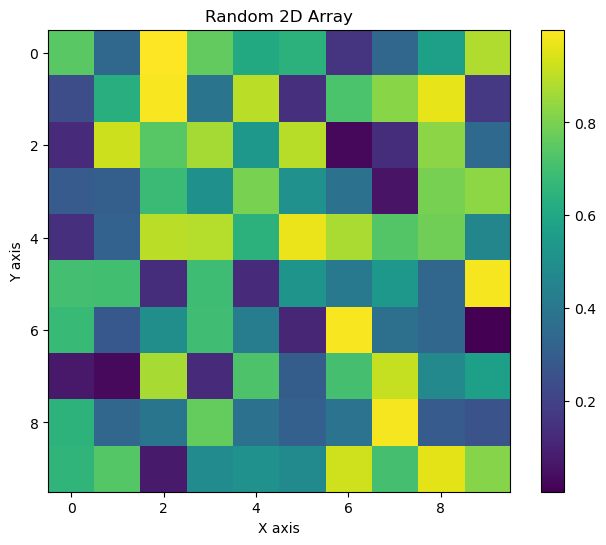

In [ ]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [ ]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == False
    if BPTT_on == True:
        assert tdBN_on == False
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.config.update(hyperparameters)
    wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
    wandb.define_metric("summary_val_acc", summary="max")
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        if (convTrue_fcFalse == False):
            if (single_step == False):
                net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                            synapse_fc_trace_const1, synapse_fc_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on).to(device)
            else:
                net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                            synapse_fc_trace_const1, synapse_fc_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on).to(device)
        else:
            if (single_step == False):
                net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
            else:
                net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()

            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################



            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################


            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)

                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)


                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    # torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            wandb.log({"summary_val_acc": val_acc_now})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [ ]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main residu test' ## 이거 설정하면 새로운 경로에 모두 save

wandb.init(project= f'my_snn {unique_name}')
my_snn_system(  devices = "5",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 0.1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin



your OTTT_sWS_on True 

지금 ottt만해라. 아니면 data_loader와서 바꿔라
Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV_sstep(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): Scale()
      (3): SYNAPSE_CONV_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Scale()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): SYNAPSE_CONV_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Scale()
      (10): SYNAPSE_CONV_trace_sstep()
      (11): LIF_layer_trace_sstep()
      (12): Scale()
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): SYNAPSE_CONV_trace_sstep()
      (15): LIF_layer_trace_sstep()
      (16): Scale()
      (17): SYNAPSE_CONV_trace_sstep()
      (18): LIF_layer_trace_sstep()
      (19): Scale()
      (20): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (21): SYNAPSE_CONV_trace_sstep()
      (22): LIF_l

train:   0%|          | 0/391 [00:00<?, ?it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-0/391 iter:11.72%, lr=['0.1'], iter_loss:2.1897177696228027, val:0.00%, val_best:0.00%:   0%|          | 1/391 [00:01<07:38,  1.18s/it]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-1/391 iter:7.81%, lr=['0.1'], iter_loss:2.1945252418518066, val:0.00%, val_best:0.00%:   1%|          | 2/391 [00:01<04:40,  1.39it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-2/391 iter:7.03%, lr=['0.1'], iter_loss:2.189544200897217, val:0.00%, val_best:0.00%:   1%|          | 3/391 [00:01<03:29,  1.85it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-3/391 iter:10.94%, lr=['0.1'], iter_loss:2.1883044242858887, val:0.00%, val_best:0.00%:   1%|          | 4/391 [00:02<03:08,  2.06it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-4/391 iter:12.50%, lr=['0.1'], iter_loss:2.197577476501465, val:0.00%, val_best:0.00%:   1%|▏         | 5/391 [00:02<02:57,  2.17it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-5/391 iter:7.03%, lr=['0.1'], iter_loss:2.1912357807159424, val:0.00%, val_best:0.00%:   2%|▏         | 6/391 [00:03<02:39,  2.41it/s]

 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNA

0-6/391 iter:7.81%, lr=['0.1'], iter_loss:2.196396827697754, val:0.00%, val_best:0.00%:   2%|▏         | 7/391 [00:03<02:38,  2.42it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-7/391 iter:11.72%, lr=['0.1'], iter_loss:2.195326566696167, val:0.00%, val_best:0.00%:   2%|▏         | 8/391 [00:03<02:28,  2.58it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-8/391 iter:8.59%, lr=['0.1'], iter_loss:2.1969122886657715, val:0.00%, val_best:0.00%:   2%|▏         | 9/391 [00:04<02:32,  2.51it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-9/391 iter:11.72%, lr=['0.1'], iter_loss:2.191513776779175, val:0.00%, val_best:0.00%:   2%|▏         | 9/391 [00:04<02:32,  2.51it/s]

18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()






0-9/391 iter:11.72%, lr=['0.1'], iter_loss:2.191513776779175, val:0.00%, val_best:0.00%:   3%|▎         | 10/391 [00:04<02:33,  2.48it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-10/391 iter:12.50%, lr=['0.1'], iter_loss:2.1958601474761963, val:0.00%, val_best:0.00%:   3%|▎         | 11/391 [00:04<02:24,  2.63it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-11/391 iter:14.06%, lr=['0.1'], iter_loss:2.179656505584717, val:0.00%, val_best:0.00%:   3%|▎         | 12/391 [00:05<02:28,  2.55it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-12/391 iter:14.84%, lr=['0.1'], iter_loss:2.1804518699645996, val:0.00%, val_best:0.00%:   3%|▎         | 13/391 [00:05<02:21,  2.67it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-13/391 iter:12.50%, lr=['0.1'], iter_loss:2.174488067626953, val:0.00%, val_best:0.00%:   3%|▎         | 13/391 [00:06<02:21,  2.67it/s] 

15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
2

0-13/391 iter:12.50%, lr=['0.1'], iter_loss:2.174488067626953, val:0.00%, val_best:0.00%:   4%|▎         | 14/391 [00:06<02:26,  2.57it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-14/391 iter:13.28%, lr=['0.1'], iter_loss:2.1812663078308105, val:0.00%, val_best:0.00%:   4%|▍         | 15/391 [00:06<02:30,  2.50it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-15/391 iter:14.06%, lr=['0.1'], iter_loss:2.173816204071045, val:0.00%, val_best:0.00%:   4%|▍         | 16/391 [00:06<02:21,  2.65it/s] 

25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SY

0-16/391 iter:10.94%, lr=['0.1'], iter_loss:2.1776628494262695, val:0.00%, val_best:0.00%:   4%|▍         | 17/391 [00:07<02:27,  2.53it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-17/391 iter:8.59%, lr=['0.1'], iter_loss:2.174611806869507, val:0.00%, val_best:0.00%:   5%|▍         | 18/391 [00:07<02:19,  2.68it/s]  





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-18/391 iter:11.72%, lr=['0.1'], iter_loss:2.1708157062530518, val:0.00%, val_best:0.00%:   5%|▍         | 19/391 [00:08<02:25,  2.55it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-19/391 iter:13.28%, lr=['0.1'], iter_loss:2.1421260833740234, val:0.00%, val_best:0.00%:   5%|▌         | 20/391 [00:08<02:28,  2.49it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-20/391 iter:9.38%, lr=['0.1'], iter_loss:2.181398391723633, val:0.00%, val_best:0.00%:   5%|▌         | 21/391 [00:08<02:21,  2.62it/s]  

25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SY

0-21/391 iter:17.19%, lr=['0.1'], iter_loss:2.137111186981201, val:0.00%, val_best:0.00%:   6%|▌         | 22/391 [00:09<02:25,  2.53it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-22/391 iter:18.75%, lr=['0.1'], iter_loss:2.1160264015197754, val:0.00%, val_best:0.00%:   6%|▌         | 23/391 [00:09<02:17,  2.67it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-23/391 iter:16.41%, lr=['0.1'], iter_loss:2.145672559738159, val:0.00%, val_best:0.00%:   6%|▌         | 23/391 [00:09<02:17,  2.67it/s] 

16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_t

0-23/391 iter:16.41%, lr=['0.1'], iter_loss:2.145672559738159, val:0.00%, val_best:0.00%:   6%|▌         | 24/391 [00:09<02:21,  2.59it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-24/391 iter:15.62%, lr=['0.1'], iter_loss:2.2041096687316895, val:0.00%, val_best:0.00%:   6%|▋         | 25/391 [00:10<02:26,  2.51it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-25/391 iter:14.84%, lr=['0.1'], iter_loss:2.126896381378174, val:0.00%, val_best:0.00%:   7%|▋         | 26/391 [00:10<02:18,  2.63it/s] 

18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
2

0-26/391 iter:11.72%, lr=['0.1'], iter_loss:2.1820600032806396, val:0.00%, val_best:0.00%:   7%|▋         | 27/391 [00:11<02:26,  2.49it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-27/391 iter:10.94%, lr=['0.1'], iter_loss:2.157841920852661, val:0.00%, val_best:0.00%:   7%|▋         | 28/391 [00:11<02:17,  2.63it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-28/391 iter:13.28%, lr=['0.1'], iter_loss:2.156139850616455, val:0.00%, val_best:0.00%:   7%|▋         | 29/391 [00:11<02:21,  2.55it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-29/391 iter:11.72%, lr=['0.1'], iter_loss:2.1688544750213623, val:0.00%, val_best:0.00%:   8%|▊         | 30/391 [00:12<02:26,  2.46it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-30/391 iter:13.28%, lr=['0.1'], iter_loss:2.174633502960205, val:0.00%, val_best:0.00%:   8%|▊         | 31/391 [00:12<02:18,  2.60it/s] 

25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SY

0-31/391 iter:24.22%, lr=['0.1'], iter_loss:2.0550851821899414, val:0.00%, val_best:0.00%:   8%|▊         | 32/391 [00:13<02:25,  2.46it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-32/391 iter:22.66%, lr=['0.1'], iter_loss:2.075822353363037, val:0.00%, val_best:0.00%:   8%|▊         | 33/391 [00:13<02:17,  2.61it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-33/391 iter:22.66%, lr=['0.1'], iter_loss:2.1697158813476562, val:0.00%, val_best:0.00%:   9%|▊         | 34/391 [00:14<03:13,  1.84it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-34/391 iter:25.00%, lr=['0.1'], iter_loss:2.112337827682495, val:0.00%, val_best:0.00%:   9%|▉         | 35/391 [00:14<03:13,  1.84it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-35/391 iter:14.06%, lr=['0.1'], iter_loss:2.1592886447906494, val:0.00%, val_best:0.00%:   9%|▉         | 36/391 [00:15<02:49,  2.09it/s]

23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()

0-36/391 iter:21.88%, lr=['0.1'], iter_loss:2.125941276550293, val:0.00%, val_best:0.00%:   9%|▉         | 37/391 [00:16<03:13,  1.83it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-37/391 iter:11.72%, lr=['0.1'], iter_loss:2.116399049758911, val:0.00%, val_best:0.00%:  10%|▉         | 38/391 [00:16<02:50,  2.07it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-38/391 iter:21.09%, lr=['0.1'], iter_loss:2.038896083831787, val:0.00%, val_best:0.00%:  10%|▉         | 39/391 [00:16<02:45,  2.13it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-39/391 iter:16.41%, lr=['0.1'], iter_loss:2.0872304439544678, val:0.00%, val_best:0.00%:  10%|█         | 40/391 [00:17<03:08,  1.86it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-40/391 iter:19.53%, lr=['0.1'], iter_loss:2.0813403129577637, val:0.00%, val_best:0.00%:  10%|█         | 41/391 [00:17<02:46,  2.11it/s]

25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SY

0-41/391 iter:25.00%, lr=['0.1'], iter_loss:2.027531385421753, val:0.00%, val_best:0.00%:  11%|█         | 42/391 [00:18<02:48,  2.08it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-42/391 iter:16.41%, lr=['0.1'], iter_loss:2.0349924564361572, val:0.00%, val_best:0.00%:  11%|█         | 43/391 [00:18<02:31,  2.30it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-43/391 iter:19.53%, lr=['0.1'], iter_loss:2.0190930366516113, val:0.00%, val_best:0.00%:  11%|█         | 43/391 [00:19<02:31,  2.30it/s]

13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, 

0-43/391 iter:19.53%, lr=['0.1'], iter_loss:2.0190930366516113, val:0.00%, val_best:0.00%:  11%|█▏        | 44/391 [00:19<02:30,  2.31it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-44/391 iter:21.88%, lr=['0.1'], iter_loss:2.051520347595215, val:0.00%, val_best:0.00%:  12%|█▏        | 45/391 [00:19<02:26,  2.36it/s] 

25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SY

0-45/391 iter:19.53%, lr=['0.1'], iter_loss:2.0573155879974365, val:0.00%, val_best:0.00%:  12%|█▏        | 46/391 [00:19<02:16,  2.53it/s]

26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 

0-46/391 iter:19.53%, lr=['0.1'], iter_loss:2.104011058807373, val:0.00%, val_best:0.00%:  12%|█▏        | 47/391 [00:20<02:21,  2.43it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-47/391 iter:20.31%, lr=['0.1'], iter_loss:1.9949127435684204, val:0.00%, val_best:0.00%:  12%|█▏        | 48/391 [00:20<02:12,  2.59it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-48/391 iter:22.66%, lr=['0.1'], iter_loss:1.967225432395935, val:0.00%, val_best:0.00%:  12%|█▏        | 48/391 [00:20<02:12,  2.59it/s] 

14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep(

0-48/391 iter:22.66%, lr=['0.1'], iter_loss:1.967225432395935, val:0.00%, val_best:0.00%:  13%|█▎        | 49/391 [00:20<02:15,  2.53it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-49/391 iter:25.00%, lr=['0.1'], iter_loss:1.977176308631897, val:0.00%, val_best:0.00%:  13%|█▎        | 50/391 [00:21<02:16,  2.51it/s]

22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0

0-50/391 iter:21.09%, lr=['0.1'], iter_loss:2.0371298789978027, val:0.00%, val_best:0.00%:  13%|█▎        | 51/391 [00:21<02:08,  2.65it/s]

25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SY

0-51/391 iter:13.28%, lr=['0.1'], iter_loss:2.0660367012023926, val:0.00%, val_best:0.00%:  13%|█▎        | 52/391 [00:22<02:11,  2.58it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-52/391 iter:29.69%, lr=['0.1'], iter_loss:1.9007651805877686, val:0.00%, val_best:0.00%:  14%|█▎        | 53/391 [00:22<02:07,  2.65it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-53/391 iter:28.91%, lr=['0.1'], iter_loss:1.9135913848876953, val:0.00%, val_best:0.00%:  14%|█▍        | 54/391 [00:22<02:14,  2.50it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-54/391 iter:17.97%, lr=['0.1'], iter_loss:2.0421793460845947, val:0.00%, val_best:0.00%:  14%|█▍        | 55/391 [00:23<02:16,  2.46it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-55/391 iter:17.19%, lr=['0.1'], iter_loss:2.0242791175842285, val:0.00%, val_best:0.00%:  14%|█▍        | 56/391 [00:23<02:08,  2.61it/s]

25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SY

0-56/391 iter:25.00%, lr=['0.1'], iter_loss:1.942701816558838, val:0.00%, val_best:0.00%:  15%|█▍        | 57/391 [00:24<02:11,  2.54it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-57/391 iter:25.00%, lr=['0.1'], iter_loss:2.024186849594116, val:0.00%, val_best:0.00%:  15%|█▍        | 58/391 [00:24<02:04,  2.67it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-58/391 iter:28.91%, lr=['0.1'], iter_loss:1.9439022541046143, val:0.00%, val_best:0.00%:  15%|█▌        | 59/391 [00:24<02:09,  2.57it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-59/391 iter:19.53%, lr=['0.1'], iter_loss:1.886583924293518, val:0.00%, val_best:0.00%:  15%|█▌        | 59/391 [00:25<02:09,  2.57it/s] 

15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()






0-59/391 iter:19.53%, lr=['0.1'], iter_loss:1.886583924293518, val:0.00%, val_best:0.00%:  15%|█▌        | 60/391 [00:25<02:11,  2.51it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-60/391 iter:24.22%, lr=['0.1'], iter_loss:1.9024012088775635, val:0.00%, val_best:0.00%:  16%|█▌        | 61/391 [00:25<02:04,  2.64it/s]

18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
2

0-61/391 iter:14.84%, lr=['0.1'], iter_loss:2.058410882949829, val:0.00%, val_best:0.00%:  16%|█▌        | 62/391 [00:26<02:08,  2.55it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-62/391 iter:27.34%, lr=['0.1'], iter_loss:1.988642930984497, val:0.00%, val_best:0.00%:  16%|█▌        | 63/391 [00:26<02:02,  2.67it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-63/391 iter:21.88%, lr=['0.1'], iter_loss:1.9858952760696411, val:0.00%, val_best:0.00%:  16%|█▋        | 64/391 [00:26<02:07,  2.56it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-64/391 iter:19.53%, lr=['0.1'], iter_loss:2.019721508026123, val:0.00%, val_best:0.00%:  17%|█▋        | 65/391 [00:27<02:10,  2.50it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-65/391 iter:20.31%, lr=['0.1'], iter_loss:1.9830793142318726, val:0.00%, val_best:0.00%:  17%|█▋        | 66/391 [00:27<02:03,  2.64it/s]

22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0

0-66/391 iter:15.62%, lr=['0.1'], iter_loss:2.142246723175049, val:0.00%, val_best:0.00%:  17%|█▋        | 67/391 [00:27<02:08,  2.52it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-67/391 iter:21.09%, lr=['0.1'], iter_loss:1.9773988723754883, val:0.00%, val_best:0.00%:  17%|█▋        | 68/391 [00:28<02:01,  2.65it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-68/391 iter:16.41%, lr=['0.1'], iter_loss:2.0134315490722656, val:0.00%, val_best:0.00%:  18%|█▊        | 69/391 [00:28<02:05,  2.56it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-69/391 iter:14.84%, lr=['0.1'], iter_loss:2.040192127227783, val:0.00%, val_best:0.00%:  18%|█▊        | 70/391 [00:29<02:09,  2.48it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-70/391 iter:23.44%, lr=['0.1'], iter_loss:1.9920798540115356, val:0.00%, val_best:0.00%:  18%|█▊        | 71/391 [00:29<02:02,  2.61it/s]

25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SY

0-71/391 iter:21.88%, lr=['0.1'], iter_loss:1.94004225730896, val:0.00%, val_best:0.00%:  18%|█▊        | 72/391 [00:29<02:05,  2.55it/s]  





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-72/391 iter:22.66%, lr=['0.1'], iter_loss:1.9286448955535889, val:0.00%, val_best:0.00%:  19%|█▊        | 73/391 [00:30<01:59,  2.67it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-73/391 iter:27.34%, lr=['0.1'], iter_loss:1.8503869771957397, val:0.00%, val_best:0.00%:  19%|█▉        | 74/391 [00:30<02:03,  2.57it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-74/391 iter:18.75%, lr=['0.1'], iter_loss:1.9663350582122803, val:0.00%, val_best:0.00%:  19%|█▉        | 75/391 [00:31<02:09,  2.45it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-75/391 iter:26.56%, lr=['0.1'], iter_loss:1.8384740352630615, val:0.00%, val_best:0.00%:  19%|█▉        | 76/391 [00:31<02:01,  2.59it/s]

18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
2

0-76/391 iter:27.34%, lr=['0.1'], iter_loss:1.8931539058685303, val:0.00%, val_best:0.00%:  20%|█▉        | 77/391 [00:31<02:04,  2.53it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-77/391 iter:25.78%, lr=['0.1'], iter_loss:1.8375245332717896, val:0.00%, val_best:0.00%:  20%|█▉        | 78/391 [00:32<01:57,  2.65it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-78/391 iter:19.53%, lr=['0.1'], iter_loss:2.109452486038208, val:0.00%, val_best:0.00%:  20%|█▉        | 78/391 [00:32<01:57,  2.65it/s] 

14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep(

0-78/391 iter:19.53%, lr=['0.1'], iter_loss:2.109452486038208, val:0.00%, val_best:0.00%:  20%|██        | 79/391 [00:32<02:01,  2.57it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-79/391 iter:26.56%, lr=['0.1'], iter_loss:1.9296317100524902, val:0.00%, val_best:0.00%:  20%|██        | 80/391 [00:33<02:06,  2.46it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-80/391 iter:21.09%, lr=['0.1'], iter_loss:1.8999133110046387, val:0.00%, val_best:0.00%:  21%|██        | 81/391 [00:33<01:59,  2.60it/s]

15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
2

0-81/391 iter:20.31%, lr=['0.1'], iter_loss:1.9303537607192993, val:0.00%, val_best:0.00%:  21%|██        | 82/391 [00:33<02:01,  2.54it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-82/391 iter:20.31%, lr=['0.1'], iter_loss:1.9782624244689941, val:0.00%, val_best:0.00%:  21%|██        | 83/391 [00:34<01:55,  2.67it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-83/391 iter:24.22%, lr=['0.1'], iter_loss:1.9166327714920044, val:0.00%, val_best:0.00%:  21%|██▏       | 84/391 [00:34<01:58,  2.60it/s]

29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)

0-84/391 iter:26.56%, lr=['0.1'], iter_loss:2.0102450847625732, val:0.00%, val_best:0.00%:  21%|██▏       | 84/391 [00:34<01:58,  2.60it/s]

26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()






0-84/391 iter:26.56%, lr=['0.1'], iter_loss:2.0102450847625732, val:0.00%, val_best:0.00%:  22%|██▏       | 85/391 [00:34<02:01,  2.52it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-85/391 iter:21.88%, lr=['0.1'], iter_loss:1.9840580224990845, val:0.00%, val_best:0.00%:  22%|██▏       | 86/391 [00:35<01:54,  2.65it/s]

19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPoo

0-86/391 iter:21.09%, lr=['0.1'], iter_loss:1.934218168258667, val:0.00%, val_best:0.00%:  22%|██▏       | 87/391 [00:35<01:58,  2.57it/s] 





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-87/391 iter:20.31%, lr=['0.1'], iter_loss:2.007340669631958, val:0.00%, val_best:0.00%:  23%|██▎       | 88/391 [00:36<01:52,  2.69it/s]





0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

0-88/391 iter:20.31%, lr=['0.1'], iter_loss:1.935299277305603, val:0.00%, val_best:0.00%:  23%|██▎       | 89/391 [00:36<02:04,  2.43it/s]






0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 LIF_layer_trace_sstep()
9 Scale()
10 SYNAPSE_CONV_trace_sstep()
11 LIF_layer_trace_sstep()
12 Scale()
13 AvgPool2d(kernel_size=2, stride=2, padding=0)
14 SYNAPSE_CONV_trace_sstep()
15 LIF_layer_trace_sstep()
16 Scale()
17 SYNAPSE_CONV_trace_sstep()
18 LIF_layer_trace_sstep()
19 Scale()
20 AvgPool2d(kernel_size=2, stride=2, padding=0)
21 SYNAPSE_CONV_trace_sstep()
22 LIF_layer_trace_sstep()
23 Scale()
24 SYNAPSE_CONV_trace_sstep()
25 LIF_layer_trace_sstep()
26 Scale()
27 AdaptiveAvgPool2d(output_size=(1, 1))
28 DimChanger_for_FC_sstep()
29 SYNAPSE_FC_trace_sstep()








0 SYNAPSE_CONV_trace_sstep()
1 LIF_layer_trace_sstep()
2 Scale()
3 SYNAPSE_CONV_trace_sstep()
4 LIF_layer_trace_sstep()
5 Scale()
6 AvgPool2d(kernel_size=2, stride=2, padding=0)
7 SYNAPSE_CONV_trace_sstep()
8 

KeyboardInterrupt: 

In [ ]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
#         "batch_size": {"values": [64, 96, 128]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init()
#     learning_rate  =  wandb.config.learning_rate
#     batch_size  =  wandb.config.batch_size
#     decay  =  wandb.config.decay

#     my_snn_system(  devices = "3",
#                     single_step = True, # True # False
#                     unique_name = run_name,
#                     my_seed = 42,
#                     TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                     BATCH = batch_size, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                     IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
#                     # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                     #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                     # DVS_CIFAR10 할거면 time 10으로 해라
#                     which_data = 'CIFAR10',
#     # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
#     # 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
#                     # CLASS_NUM = 10,
#                     data_path = '/data2', # YOU NEED TO CHANGE THIS
#                     rate_coding = False, # True # False

#                     lif_layer_v_init = 0.0,
#                     lif_layer_v_decay = decay,
#                     lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                     lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                     lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

#                     # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                     synapse_conv_kernel_size = 3,
#                     synapse_conv_stride = 1,
#                     synapse_conv_padding = 1,
#                     synapse_conv_trace_const1 = 1,
#                     synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                     # synapse_fc_out_features = CLASS_NUM,
#                     synapse_fc_trace_const1 = 1,
#                     synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                     pre_trained = False, # True # False
#                     convTrue_fcFalse = True, # True # False

#                     # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                     # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                     # cfg = [64],
#                     # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                     cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                     # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
#                     # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                     # cfg = [20001,10001], # depthwise, separable
#                     # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                     # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                     # cfg = [], 
                    
#                     net_print = True, # True # False
#                     weight_count_print = False, # True # False
                    
#                     pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
#                     learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
#                     epoch_num = 4,
#                     verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                     validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                     tdBN_on = False,  # True # False
#                     BN_on = False,  # True # False
                    
#                     surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                    
#                     gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                     BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                     optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                     scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                    
#                     ddp_on = False,   # True # False

#                     nda_net = False,   # True # False

#                     domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                    
#                     dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
#                     dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                     #있는 데이터들 #gesture 1000000 #nmnist 10000

#                     OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                    
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=1000)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json




# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()